In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy import linalg
import os
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import random
import ast
from functools import reduce

In [2]:
dis_male = pd.read_csv('disclosed_male.csv',sep='|')

In [3]:
dis_male.columns

Index(['Upvotes', 'Downvotes', 'Rating', 'Timestamp', 'Review_length',
       'Grade_level', 'overall_sentiment', 'categories'],
      dtype='object')

In [4]:
dis_female = pd.read_csv('disclosed_female.csv',sep='|')

In [5]:
dis_female.columns

Index(['Upvotes', 'Downvotes', 'Rating', 'Timestamp', 'Review_length',
       'Grade_level', 'overall_sentiment', 'categories'],
      dtype='object')

In [6]:
undis_male = pd.read_csv('undisclosed_male.csv',sep='|')

In [7]:
undis_female = pd.read_csv('undisclosed_female.csv',sep='|')

In [8]:
undis_male.columns

Index(['Upvotes', 'Downvotes', 'Rating', 'Timestamp', 'Review_length',
       'Grade_level', 'overall_sentiment', 'categories'],
      dtype='object')

In [21]:
cat = undis_male.iloc[0]['categories'].replace('[','').replace(']','').replace('\'','').split(',')

In [52]:
def getCategoryList(x):
    return reduce(lambda a,b:a+b,ast.literal_eval(x))

In [53]:
undis_male['categories'] = undis_male['category'].apply(lambda x:getCategoryList(x))

In [54]:
undis_male = undis_male.drop(columns=['category'])

In [55]:
undis_male.iloc[0]['categories']

['Clothing, Shoes & Jewelry',
 'Shoes & Accessories: International Shipping Available',
 'Clothing, Shoes & Jewelry',
 'O',
 'Osiris',
 'Clothing, Shoes & Jewelry',
 'Street, Surf & Skate',
 'Clothing, Shoes & Jewelry',
 'Men',
 'Shoes',
 'Fashion Sneakers',
 'Clothing, Shoes & Jewelry',
 'Men',
 'Shoes',
 'Athletic',
 'Skateboarding']

In [57]:
undis_female = undis_female.rename(columns={'categories':'category'})

In [58]:
undis_female.head()

,Upvotes,Downvotes,Rating,Timestamp,Review_length,Grade_level,overall_sentiment,category
0,0.0,0.0,5.0,1.404086e+09,2.0,15.0,0.4404,"[['Home & Kitchen', 'Bedding', 'Comforters & S..."
1,0.0,1.0,4.0,1.365725e+09,24.0,4.0,0.6597,"[['Home & Kitchen', 'Bedding', 'Comforters & S..."
2,0.0,0.0,2.0,1.398038e+09,68.0,4.0,0.9571,"[['Home & Kitchen', 'Bedding', 'Comforters & S..."
3,1.0,1.0,1.0,1.367539e+09,165.0,6.0,0.9241,"[['Home & Kitchen', 'Bedding', 'Comforters & S..."
4,0.0,0.0,5.0,1.395101e+09,21.0,8.0,0.8020,"[['Home & Kitchen', 'Bedding', 'Comforters & S..."


In [59]:
undis_female['categories'] = undis_female['category'].apply(lambda x:getCategoryList(x))

In [60]:
undis_female.head()

,Upvotes,Downvotes,Rating,Timestamp,Review_length,Grade_level,overall_sentiment,category,categories
0,0.0,0.0,5.0,1.404086e+09,2.0,15.0,0.4404,"[['Home & Kitchen', 'Bedding', 'Comforters & S...","[Home & Kitchen, Bedding, Comforters & Sets, C..."
1,0.0,1.0,4.0,1.365725e+09,24.0,4.0,0.6597,"[['Home & Kitchen', 'Bedding', 'Comforters & S...","[Home & Kitchen, Bedding, Comforters & Sets, C..."
2,0.0,0.0,2.0,1.398038e+09,68.0,4.0,0.9571,"[['Home & Kitchen', 'Bedding', 'Comforters & S...","[Home & Kitchen, Bedding, Comforters & Sets, C..."
3,1.0,1.0,1.0,1.367539e+09,165.0,6.0,0.9241,"[['Home & Kitchen', 'Bedding', 'Comforters & S...","[Home & Kitchen, Bedding, Comforters & Sets, C..."
4,0.0,0.0,5.0,1.395101e+09,21.0,8.0,0.8020,"[['Home & Kitchen', 'Bedding', 'Comforters & S...","[Home & Kitchen, Bedding, Comforters & Sets, C..."


In [61]:
undis_female = undis_female.drop(columns=['category'])

In [62]:
dis_female = dis_female.rename(columns={'categories':'category'})
dis_female['categories'] = dis_female['category'].apply(lambda x:getCategoryList(x))
dis_female = dis_female.drop(columns=['category'])

In [63]:
dis_male = dis_male.rename(columns={'categories':'category'})
dis_male['categories'] = dis_male['category'].apply(lambda x:getCategoryList(x))
dis_male = dis_male.drop(columns=['category'])

In [64]:
def filterCategory(x,category):
    if category in x:
        return True
    return False

In [89]:
def calculateCdist(df_1_s,df_2,cov_inv):
    cnt = df_2.shape[0]
    slice_len = 250000
    obtained_pairs = []
    similarity_val = []
    n = df_1_s.shape[0]
    if cnt>slice_len:
    
        slice_cnt = int(cnt/slice_len)+1
        for i in range(slice_cnt):
            u_s = i*slice_len
            
            if i < slice_cnt-1:
                u_e = u_s + slice_len
                df_2_s = df_2[u_s:u_e]
            else:
                df_2_s = df_2[u_s:]

            Y = distance.cdist(df_1_s[['Rating','Timestamp','Review_length','Grade_level','overall_sentiment']], \
                               df_2_s[['Rating','Timestamp','Review_length','Grade_level','overall_sentiment']], \
                               'mahalanobis', VI=cov_inv)
            Y_1 = Y.argmin(axis=1)


            min_y = [(Y_1[j],Y[j,Y_1[j]],i) for j in range(n)]
            obtained_pairs.append(min_y)

        # obtaining the matched set
        matched_set = []
        for i in range(n):
            for ind,val,s in sorted(list(zip(*obtained_pairs))[i],key=lambda x:x[1]):
                pos = s*slice_len+ind
                matched_set.append(pos)
                similarity_val.append(val)
                break
        
        return matched_set,similarity_val
    
    else:
        Y = distance.cdist(df_1_s[['Rating','Timestamp','Review_length','Grade_level','overall_sentiment']], \
                           df_2[['Rating','Timestamp','Review_length','Grade_level','overall_sentiment']], \
                           'mahalanobis', VI=cov_inv)
        Y_1 = Y.argmin(axis=1)
        
        for i in range(Y.shape[0]):
            similarity_val.append(Y[i,Y_1[i]])
        
        return Y_1,similarity_val

In [281]:
def findMatchAllPairs(d_m,d_f,u_m,u_f,sample_size):
    
    pairs = {}
    
    #d_m.insert(8,'group',0)
    #d_f.insert(8,'group',1)
    #u_m.insert(8,'group',2)
    #u_f.insert(8,'group',3)
    
    all_data = pd.concat([d_m,d_f,u_m,u_f])
    
    sample_n = all_data.sample(sample_size)
    
    samp_0 = sample_n[sample_n['group']==0]
    samp_1 = sample_n[sample_n['group']==1]
    samp_2 = sample_n[sample_n['group']==2]
    samp_3 = sample_n[sample_n['group']==3]
    
    #print(f'sample DM - {len(samp_0)}, sample DF - {len(samp_1)}, \
    #sample UM - {len(samp_2)}, sample UF - {len(samp_3)}')
    
    data = [(samp_0,0),(samp_1,1),(samp_2,2),(samp_3,3)]
    
    for i in range(3):
        
        samp_0,label_0 = data[i][0],data[i][1]
        popln_0 = all_data[all_data['group']==label_0]
        
        for j in range(i+1,4):
            
            samp_1,label_1 = data[j][0],data[j][1]    
            popln_1 = all_data[all_data['group']==label_1]

            pop_size = popln_0.shape[0] + popln_1.shape[0]
            
            if pop_size<1000000:
                m = pop_size
            else:
                m = 1000000

            all_sample = pd.concat([popln_0,popln_1])
        
            cov = np.cov(all_sample[['Rating','Timestamp','Review_length','Grade_level','overall_sentiment']] \
                         .sample(m).values, rowvar=False)
            cov_inv = linalg.inv(cov)

            print('covariance matrix obtained')
            
            Y_1,similarity_1 = calculateCdist(samp_0,popln_1,cov_inv) 
            
            pair_0_0 = [samp_0.iloc[i] for i in range(samp_0.shape[0])]
            pair_1_0 = [popln_1.iloc[i] for i in Y_1]
            
            pairs[str(label_0)+'-'+str(label_1)] = list(zip(pair_0_0,pair_1_0)) 
            
            Y_1,similarity_2 = calculateCdist(samp_1,popln_0,cov_inv)
            
            pair_0_1 = [popln_0.iloc[i] for i in Y_1]

            pair_1_1 = [samp_1.iloc[i] for i in range(samp_1.shape[0])]
            
            pairs[str(label_1)+'-'+str(label_0)] = list(zip(pair_0_1,pair_1_1))
            
                
    return pairs  #,similarity_1,similarity_2                
                

In [67]:
category = 'Toys & Games'

In [68]:
dis_male_c = dis_male[dis_male['categories'].apply(lambda x:filterCategory(x,category))]

In [69]:
dis_male_c.head()

,Upvotes,Downvotes,Rating,Timestamp,Review_length,Grade_level,overall_sentiment,categories
2750,0,0,5.0,1.384214e+09,22.0,6.0,0.8271,"[Toys & Games, Building Toys, Building Sets]"
2751,0,0,5.0,1.388448e+09,22.0,7.0,0.7453,"[Toys & Games, Building Toys, Building Sets]"
2752,0,0,5.0,1.388621e+09,31.0,9.0,0.7650,"[Toys & Games, Building Toys, Building Sets]"
2753,0,0,4.0,1.373933e+09,41.0,3.0,-0.0772,"[Toys & Games, Building Toys, Building Sets]"
2754,0,0,5.0,1.389485e+09,36.0,4.0,0.8074,"[Toys & Games, Building Toys, Building Sets]"


In [70]:
dis_female_c = dis_female[dis_female['categories'].apply(lambda x:filterCategory(x,category))]
undis_male_c = undis_male[undis_male['categories'].apply(lambda x:filterCategory(x,category))]
undis_female_c = undis_female[undis_female['categories'].apply(lambda x:filterCategory(x,category))]

In [71]:
dis_female_c.head()

,Upvotes,Downvotes,Rating,Timestamp,Review_length,Grade_level,overall_sentiment,categories
3640,0,0,5.0,1.375661e+09,55.0,4.0,0.6389,"[Toys & Games, Building Toys, Building Sets]"
3641,0,1,4.0,1.360195e+09,25.0,5.0,0.7096,"[Toys & Games, Building Toys, Building Sets]"
3642,0,0,5.0,1.376006e+09,24.0,5.0,0.8519,"[Toys & Games, Building Toys, Building Sets]"
3643,0,1,3.0,1.388794e+09,19.0,9.0,0.3182,"[Toys & Games, Building Toys, Building Sets]"
3644,0,0,5.0,1.388189e+09,116.0,6.0,0.8310,"[Toys & Games, Building Toys, Building Sets]"


In [283]:
pairs = findMatchAllPairs(dis_male_c,dis_female_c,undis_male_c,undis_female_c,1000)

covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained


In [284]:
pairs.keys()

dict_keys(['0-1', '1-0', '0-2', '2-0', '0-3', '3-0', '1-2', '2-1', '1-3', '3-1', '2-3', '3-2'])

In [278]:
categories = ['Books','Electronics','CDs & Vinyl','Clothing, Shoes & Jewelry','Home & Kitchen',\
             'Kindle Store','Sports & Outdoors','Cell Phones & Accessories', 'Toys & Games','Games','Literature & Fiction',\
             'Beauty','Health & Personal Care','Movies','Computers']

In [285]:
dis_male.insert(8,'group',0)
dis_female.insert(8,'group',1)
undis_male.insert(8,'group',2)
undis_female.insert(8,'group',3)

for _ in range(1,11):

    for category in categories:
        
        print(f'category - {category}')
        
        d_m_c = dis_male[dis_male['categories'].apply(lambda x:filterCategory(x,category))]
        d_f_c = dis_female[dis_female['categories'].apply(lambda x:filterCategory(x,category))]
        u_m_c = undis_male[undis_male['categories'].apply(lambda x:filterCategory(x,category))]
        u_f_c = undis_female[undis_female['categories'].apply(lambda x:filterCategory(x,category))]

        pairs = findMatchAllPairs(d_m_c,d_f_c,u_m_c,u_f_c,10000)
        
        path = 'category_pairs/sample_'+str(_)+'/'+category+'.pickle'
        
        with open(path,'wb') as ft:
            pickle.dump(pairs,ft)
    
    print(f'finished sample - {_}')
        

category - Books
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Electronics
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - CDs & Vinyl
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Clothing, Shoes & Jewelry
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Home & Kitchen
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Kindle Store
covariance matrix obtained
covariance ma

covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Computers
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
finished sample - 3
category - Books
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Electronics
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - CDs & Vinyl
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Clothing, Shoes & Jewelry
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obta

category - Health & Personal Care
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Movies
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Computers
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
finished sample - 6
category - Books
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Electronics
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - CDs & Vinyl
covariance matrix obtained
covaria

covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Beauty
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Health & Personal Care
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Movies
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
category - Computers
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
finished sample - 9
category - Books
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covarian

In [145]:
from scipy.spatial.distance import mahalanobis

In [146]:
mahalanobis(val_1,val_2,cov_inv)

0.061391273320486696

In [148]:
similarity_1[0]

0.061391273320486696

In [152]:
def perIncr(x,y):
    return (x-y)/min([x,y])*100

In [156]:
def calculateMean(h):
    return np.mean([x[0] for x in h]),np.mean([x[1] for x in h])

In [242]:
def calculateMetric(pairs,bootstrap=False):
    
    res = {}
    
    for i in range(3):
        for j in range(i+1,4):
            key_1 = str(i)+'-'+str(j)
            key_2 = str(j)+'-'+str(i)
            
            h1 = [(m_1.Upvotes - m_1.Downvotes,m_2.Upvotes - m_2.Downvotes) for m_1,m_2 in pairs[key_1]]
            h2 = [(m_2.Upvotes - m_2.Downvotes,m_1.Upvotes - m_1.Downvotes) for m_1,m_2 in pairs[key_2]]
            
            if bootstrap:
                est = []
                for _ in range(1000):
                    h_s_1,h_s_2 = calculateMean(h1+h2)
                    est.append(perIncr(h_s_1,h_s_2))
                
                res[key_1] = (np.mean(est),stats.sem(est))
            
            else:
                
                h_s_1,h_s_2 = calculateMean(h1+h2)
                res[key_1] = (perIncr(h_s_1,h_s_2))

        break    
                
    return res            
                
            

In [161]:
calculateMetric(pairs,True)

{'0-1': (24.80769230769232, 3.3720865948527714e-16)}

In [200]:
from scipy.stats import ks_2samp

In [276]:
def calcCovariateDist(pairs,t,covariate='Grade_level'):
    
    flag = 0
    dists_all = []
    for i in range(4):
        if i!=t:
            if flag==0:
                grp_0_1 = [(m[covariate],n[covariate]) for m,n in pairs[str(t)+'-'+str(i)]]
                #grp_1_0 = [(n[covariate],m[covariate]) for m,n in pairs[str(i)+'-'+str(t)]]
                #grp = grp_0_1 + grp_1_0
                dist = list(zip(*grp_0_1))
            
                dist_0 = list(dist[0])
                dists_all.append(list(dist[1]))
            
            else:
                dists_all.append([n[covariate] for m,n in pairs[str(t)+'-'+str(i)]])
                
            #val,p = ks_2samp(dist_0,dist_1)
            #print(val,p)
            #dist_0.sort()
            #dist_1.sort()
            #y_1 = np.cumsum(dist_0)
            #y_2 = np.cumsum(dist_1)
            
    #y,binEdges=np.histogram(dist_0,bins=100)
    #bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    #plt.plot(bincenters,y,'-',linewidth=2)
    sns.distplot(dist_0,hist=False,rug=True,label='DM',kde_kws={'color':'b','linewidth':2})
    
    colors = ['r','b','r']
    ls = ['-','--','--']
    labels = ['DF','UM','UF']
    
    for i,dist in enumerate(dists_all):

        #y,binEdges=np.histogram(dist,bins=100)
        #bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        #plt.plot(bincenters,y,'-',linewidth=2)
        sns.distplot(dist,hist=False,rug=True,label=labels[i],
                     kde_kws={'color':colors[i],'linestyle':ls[i],'linewidth':2})

    plt.xlabel('Readability')
    plt.ylabel('PDF')
    plt.grid(linestyle='--')
    #plt.tight_layout()
    
            
            
    

In [179]:
pairs['0-1'][100]

(Upvotes                                                              2
 Downvotes                                                            0
 Rating                                                               5
 Timestamp                                                   1.3182e+09
 Review_length                                                      416
 Grade_level                                                          8
 overall_sentiment                                               0.9698
 categories           [Toys & Games, Hobbies, Models & Model Kits, M...
 group                                                                0
 Name: 17370889, dtype: object,
 Upvotes                                                       125
 Downvotes                                                       0
 Rating                                                          5
 Timestamp                                             1.31337e+09
 Review_length                                      

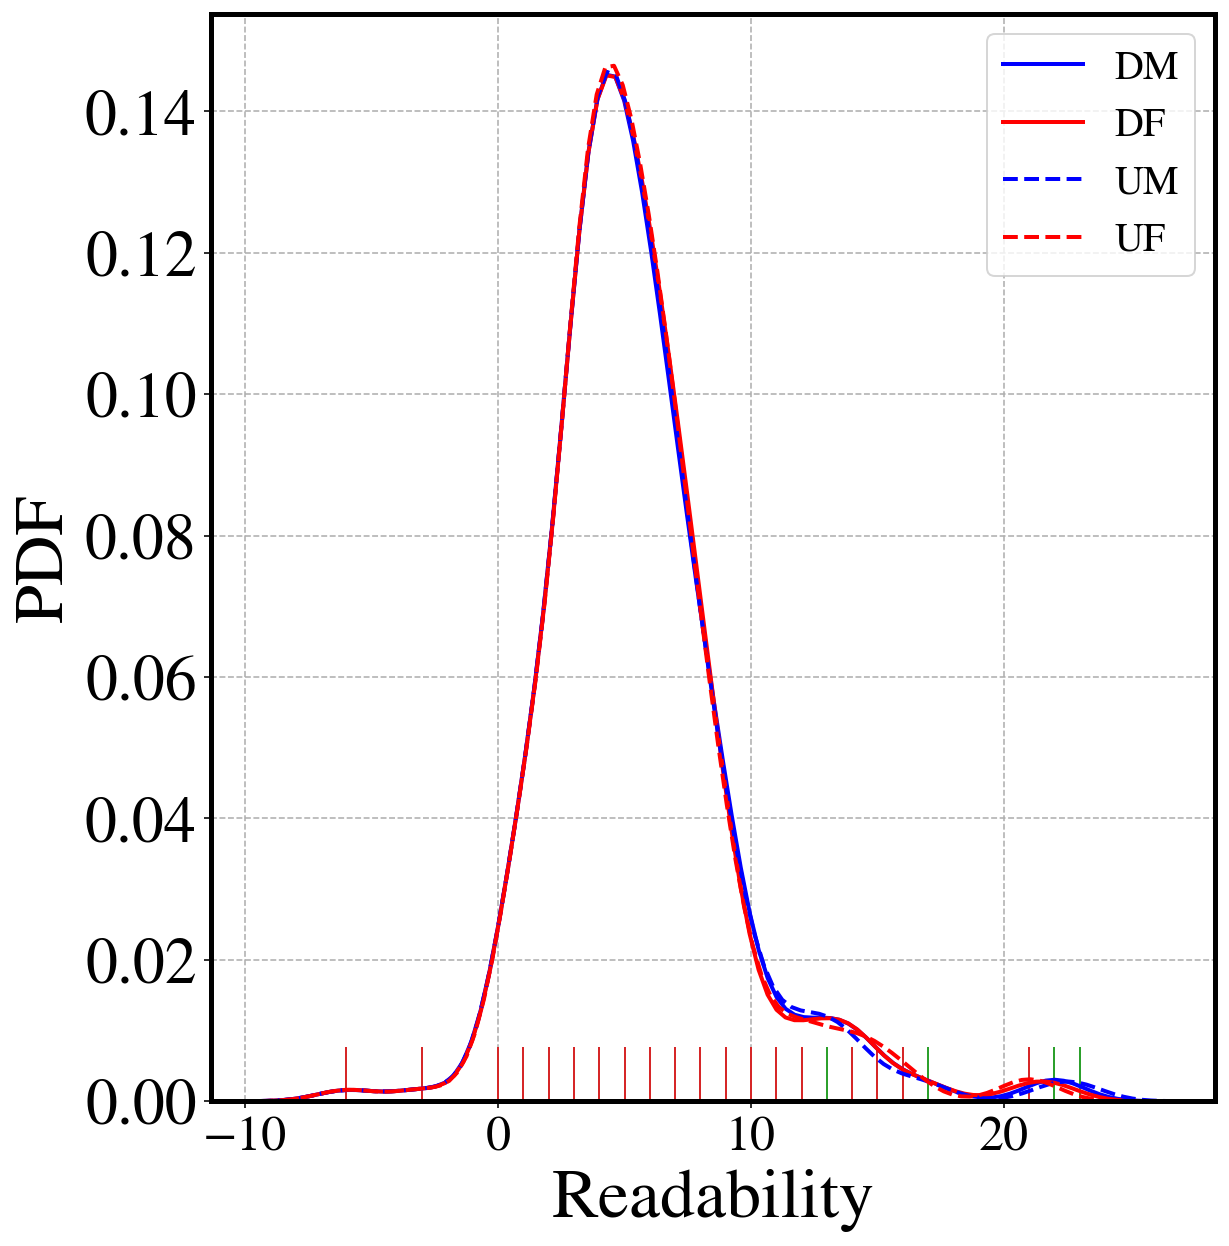

In [277]:
calcCovariateDist(pairs,0)

In [199]:
from scipy.stats import kruskal

In [203]:
d_m_s = dis_male.sample(1000000)

In [204]:
u_m_s = undis_male.sample(1000000)

In [205]:
d_f_s = dis_female.sample(1000000)

In [206]:
u_f_s = undis_female.sample(1000000)

In [209]:
kruskal(d_m_s['overall_sentiment'],u_m_s['overall_sentiment'],d_f_s['overall_sentiment'],u_f_s['overall_sentiment'])

KruskalResult(statistic=79577.3095196141, pvalue=0.0)

In [213]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib as mpl

In [214]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#mpl.style.use('classic')
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 32
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] =  9,10
mpl.rcParams['axes.labelsize'] = 35
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['axes.linewidth'] = 2.5

0.017361111111111112 0.9999946040688373


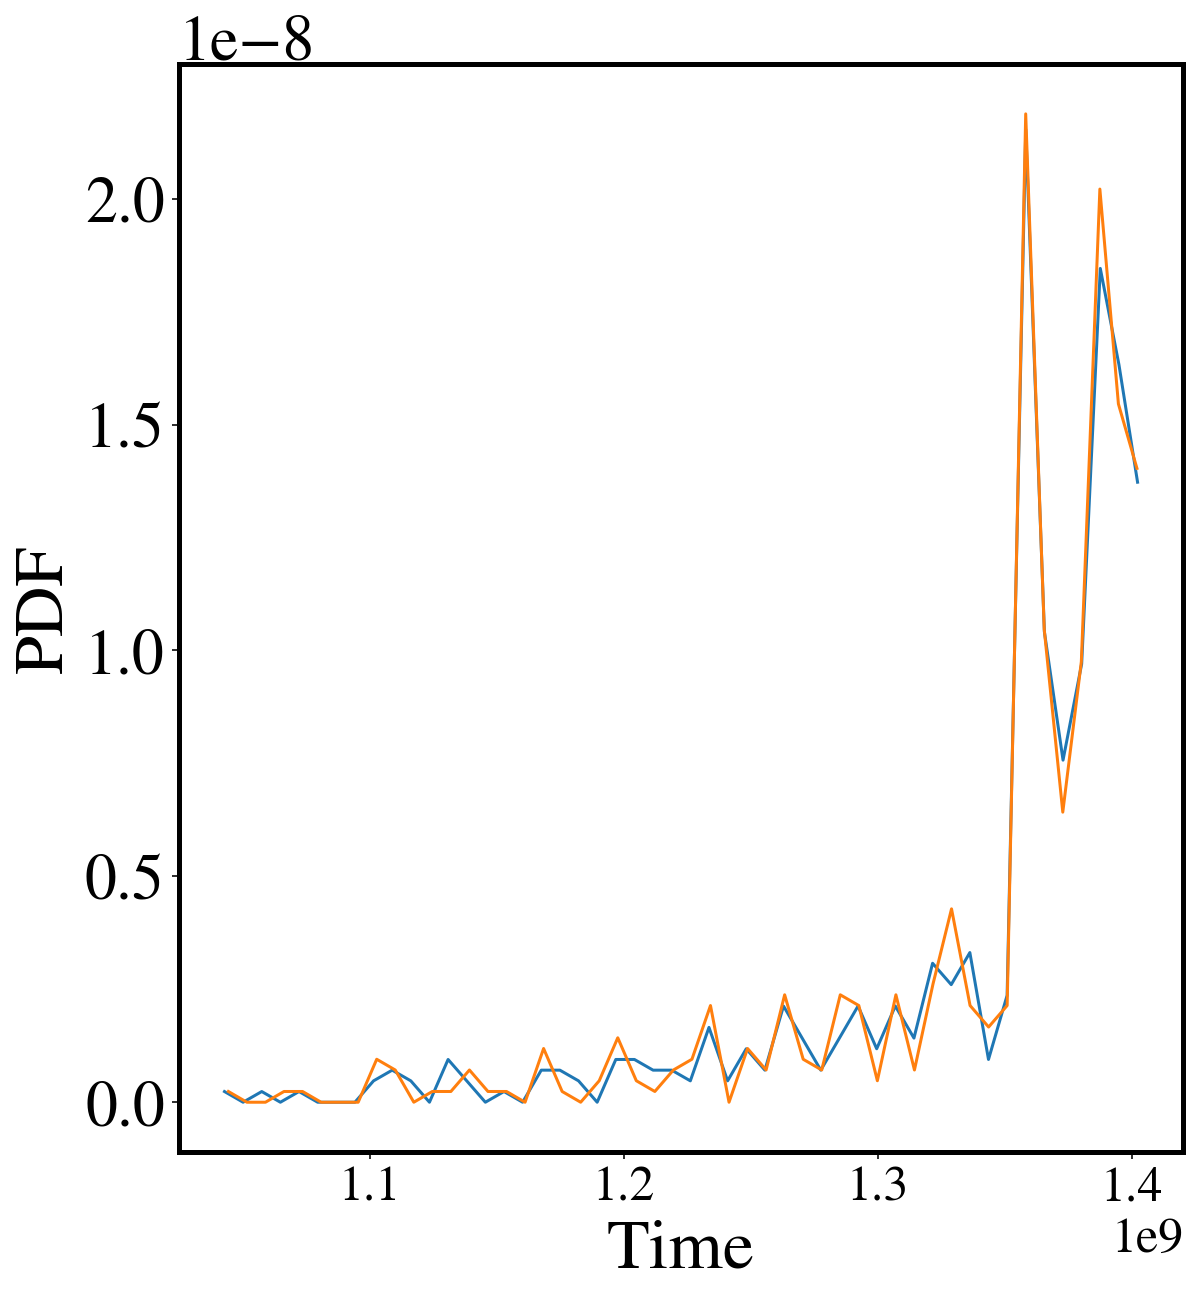

In [221]:
calcCovariateDist(pairs,0)

In [249]:
import seaborn as sns